Hypothesis: We might be representation bottlenecked and that might be contributing to our less than ideal performance. What if we start by pretraining our network to do autoencoding, chop off the decoder, and then do our metric learning on that

In [1]:
import transformer_lens
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from sklearn.decomposition import PCA
import numpy as np

import torch.nn.functional as F

from tqdm import tqdm

import random

In [2]:
seed = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [3]:
# Load datasets
train_set = load_dataset("sentence-transformers/stsb", split="train")
val_set   = load_dataset("sentence-transformers/stsb", split="validation")
test_set  = load_dataset("sentence-transformers/stsb", split="test")

first_train  = torch.load('gpt2_medium_train_acts_1.npy')
second_train = torch.load('gpt2_medium_train_acts_2.npy')

first_test = torch.load('gpt2_medium_test_acts_1.npy')
second_test = torch.load('gpt2_medium_test_acts_2.npy')

wikitext_acts = torch.load('generics_kb_10k_10272024.npy')

train_scores = torch.Tensor(train_set['score'])
test_scores = torch.Tensor(test_set['score'])

 10%|██████▊                                                             | 10/100 [01:02<09:29,  6.32s/it]


Epoch 10
Train Losses - Early: 0.214, Mid: 0.853, Late: 8.338
Test Losses  - Early: 1.163, Mid: 4.034, Late: 22.649


 20%|█████████████▌                                                      | 20/100 [02:06<08:37,  6.47s/it]


Epoch 20
Train Losses - Early: 0.150, Mid: 0.580, Late: 4.964
Test Losses  - Early: 1.034, Mid: 3.464, Late: 16.784


 30%|████████████████████▍                                               | 30/100 [03:10<07:29,  6.43s/it]


Epoch 30
Train Losses - Early: 0.115, Mid: 0.459, Late: 3.769
Test Losses  - Early: 0.966, Mid: 3.196, Late: 14.704


 40%|███████████████████████████▏                                        | 40/100 [04:15<06:28,  6.47s/it]


Epoch 40
Train Losses - Early: 0.089, Mid: 0.374, Late: 3.151
Test Losses  - Early: 0.933, Mid: 3.050, Late: 13.833


 50%|██████████████████████████████████                                  | 50/100 [05:19<05:20,  6.42s/it]


Epoch 50
Train Losses - Early: 0.071, Mid: 0.319, Late: 2.604
Test Losses  - Early: 0.922, Mid: 2.971, Late: 12.995


 60%|████████████████████████████████████████▊                           | 60/100 [06:22<04:14,  6.37s/it]


Epoch 60
Train Losses - Early: 0.058, Mid: 0.276, Late: 2.341
Test Losses  - Early: 0.912, Mid: 2.915, Late: 12.481


 70%|███████████████████████████████████████████████▌                    | 70/100 [07:26<03:09,  6.30s/it]


Epoch 70
Train Losses - Early: 0.049, Mid: 0.248, Late: 2.023
Test Losses  - Early: 0.912, Mid: 2.883, Late: 11.994


 80%|██████████████████████████████████████████████████████▍             | 80/100 [08:28<02:07,  6.38s/it]


Epoch 80
Train Losses - Early: 0.044, Mid: 0.231, Late: 1.835
Test Losses  - Early: 0.913, Mid: 2.867, Late: 11.715


 90%|█████████████████████████████████████████████████████████████▏      | 90/100 [09:31<01:04,  6.43s/it]


Epoch 90
Train Losses - Early: 0.040, Mid: 0.218, Late: 1.710
Test Losses  - Early: 0.917, Mid: 2.854, Late: 11.548


100%|███████████████████████████████████████████████████████████████████| 100/100 [10:34<00:00,  6.35s/it]


Epoch 100
Train Losses - Early: 0.037, Mid: 0.200, Late: 1.496
Test Losses  - Early: 0.917, Mid: 2.821, Late: 11.178


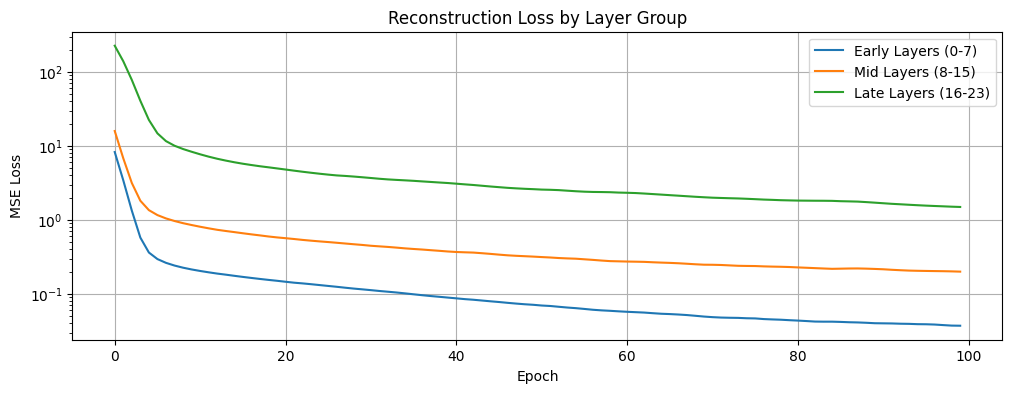

In [4]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in),
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        # Add residual connection for easier learning
        return self.decode(h) + 0.1 * x  # Scaled residual to start mostly from identity

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self, mlp):
        super().__init__()
        self.mlp = mlp

    def forward(self, x1, x2):
        h1 = self.mlp(x1)
        h2 = self.mlp(x2)
        return F.cosine_similarity(h1, h2, dim=-1)

class LayerwiseSiameseNetworks(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256):
        super().__init__()
        self.n_layers = n_layers
        self.layer_nets = nn.ModuleList([SiameseNetwork(encoders[i]) for i in range(n_layers)])

    def forward(self, x1, x2):
        similarities = []
        for layer in range(self.n_layers):
            net_at_layer = self.layer_nets[layer].cuda()
            # Get the activations at the given layer
            x1_l = x1[:, layer].cuda()
            x2_l = x2[:, layer].cuda()

            sim_at_layer = net_at_layer(x1_l, x2_l)
            # print(sim_at_layer.shape)
            similarities.append(sim_at_layer)

        return torch.stack(similarities, dim=-1)

class SimilarityLearner(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256, d_out_hidden=512, dropout=0.1):
        super().__init__()
        self.layer_nets = LayerwiseSiameseNetworks(encoders, n_layers, d_in, d_hidden)

        self.mlp = nn.Sequential(
            nn.Linear(n_layers, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, 1),
            nn.Hardsigmoid()
        )

    def forward(self, x1, x2, training=True):
        layerwise_similarities = self.layer_nets(x1, x2)
        similarity = self.mlp(layerwise_similarities)
        return similarity.squeeze()

In [7]:
from copy import deepcopy
cloned_encoders = [deepcopy(e).encode for e in encoders]

similarity_learner = SimilarityLearner(cloned_encoders, d_hidden=512).to('cuda:0')
# similarity_learner = SimilarityLearner([Autoencoder(i) for i in range(24)], d_hidden=512).to('cuda:0')
optimizer = torch.optim.Adam(similarity_learner.parameters(), lr=3e-5)

def train_epoch(model, first_acts, second_acts, scores, optimizer, batch_size=32):
    model.train()
    total_loss = 0
    n_batches = first_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        x1_batch = first_acts[start_idx:end_idx].cuda()
        x2_batch = second_acts[start_idx:end_idx].cuda()
        scores_batch = scores[start_idx:end_idx].cuda()
        
        optimizer.zero_grad()
        
        sims = model(x1_batch, x2_batch)
        
        loss = F.mse_loss(sims, scores_batch)        
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / n_batches

best_test_corr = 0
best_model = None

for epoch in tqdm(range(100)):
    # Training
    loss = train_epoch(similarity_learner, first_train, second_train, train_scores, optimizer)
    
    # Evaluation
    similarity_learner.eval()
    with torch.no_grad():
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Get training correlations
            train_preds = similarity_learner(first_train.cuda(), second_train.cuda(), training=False)
            train_corr = torch.corrcoef(torch.stack([train_preds.cpu(), train_scores]))[0,1]
            
            # Get test correlations
            test_preds = similarity_learner(first_test.cuda(), second_test.cuda(), training=False)
            test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]

            if test_corr > best_test_corr:
                best_test_corr = test_corr
                best_model = deepcopy(similarity_learner)

            print(f"Epoch {epoch+1}")
            print(f"Loss: {loss:.4f}")
            print(f"Train correlation: {train_corr:.4f}")
            print(f"Test correlation: {test_corr:.4f}\n")

 10%|██████▊                                                             | 10/100 [00:59<09:08,  6.10s/it]

Epoch 10
Loss: 0.0163
Train correlation: 0.9075
Test correlation: 0.6731



 20%|█████████████▌                                                      | 20/100 [02:02<08:27,  6.34s/it]

Epoch 20
Loss: 0.0086
Train correlation: 0.9433
Test correlation: 0.7303



 30%|████████████████████▍                                               | 30/100 [03:06<07:31,  6.45s/it]

Epoch 30
Loss: 0.0064
Train correlation: 0.9662
Test correlation: 0.7355



 40%|███████████████████████████▏                                        | 40/100 [04:10<06:26,  6.45s/it]

Epoch 40
Loss: 0.0031
Train correlation: 0.9483
Test correlation: 0.7246



 50%|██████████████████████████████████                                  | 50/100 [05:13<05:07,  6.15s/it]

Epoch 50
Loss: 0.0028
Train correlation: 0.9719
Test correlation: 0.7291



 60%|████████████████████████████████████████▊                           | 60/100 [06:14<04:13,  6.33s/it]

Epoch 60
Loss: 0.0017
Train correlation: 0.9771
Test correlation: 0.7410



 70%|███████████████████████████████████████████████▌                    | 70/100 [07:16<03:10,  6.35s/it]

Epoch 70
Loss: 0.0018
Train correlation: 0.9765
Test correlation: 0.7408



 80%|██████████████████████████████████████████████████████▍             | 80/100 [08:20<02:07,  6.37s/it]

Epoch 80
Loss: 0.0014
Train correlation: 0.9841
Test correlation: 0.7355



 90%|█████████████████████████████████████████████████████████████▏      | 90/100 [09:24<01:03,  6.38s/it]

Epoch 90
Loss: 0.0011
Train correlation: 0.9830
Test correlation: 0.7436



100%|███████████████████████████████████████████████████████████████████| 100/100 [10:27<00:00,  6.28s/it]

Epoch 100
Loss: 0.0009
Train correlation: 0.9887
Test correlation: 0.7434



In [8]:
test_preds = best_model(first_test.cuda(), second_test.cuda(), training=False)
test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]
print(test_corr)

tensor(0.7436, grad_fn=<SelectBackward0>)


In [10]:
param_count = sum([w.numel() for w in similarity_learner.parameters()])
f"This model has {param_count} parameters!"

'This model has 30158977 parameters!'